In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('Datasets\combined_data.csv')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\SIDDHARTH\AppData\Local\Temp\ipykernel_25032\2519955126.py:1: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv('Datasets\combined_data.csv')


In [4]:
df = df.dropna()

In [5]:
df_processed = pd.get_dummies(df, columns=['Frabrication method'], drop_first=True)

In [6]:
numerical_cols = ['Zn wt% ', 'Li wt%', 'Mg wt%', 'Ca wt%', 'Ce wt%', 'Yb wt%', 
                  'Mn wt%', 'Al wt%', 'Cu wt%', 'Sr wt%', 'Ti wt%', 'Mo wt%', 
                  'Sc wt%', 'Zr wt%', 'YS (Mpa)', 'UTS (Mpa)', 'Elongation (%)', 
                  'Corrosion rate (mm/yr)']

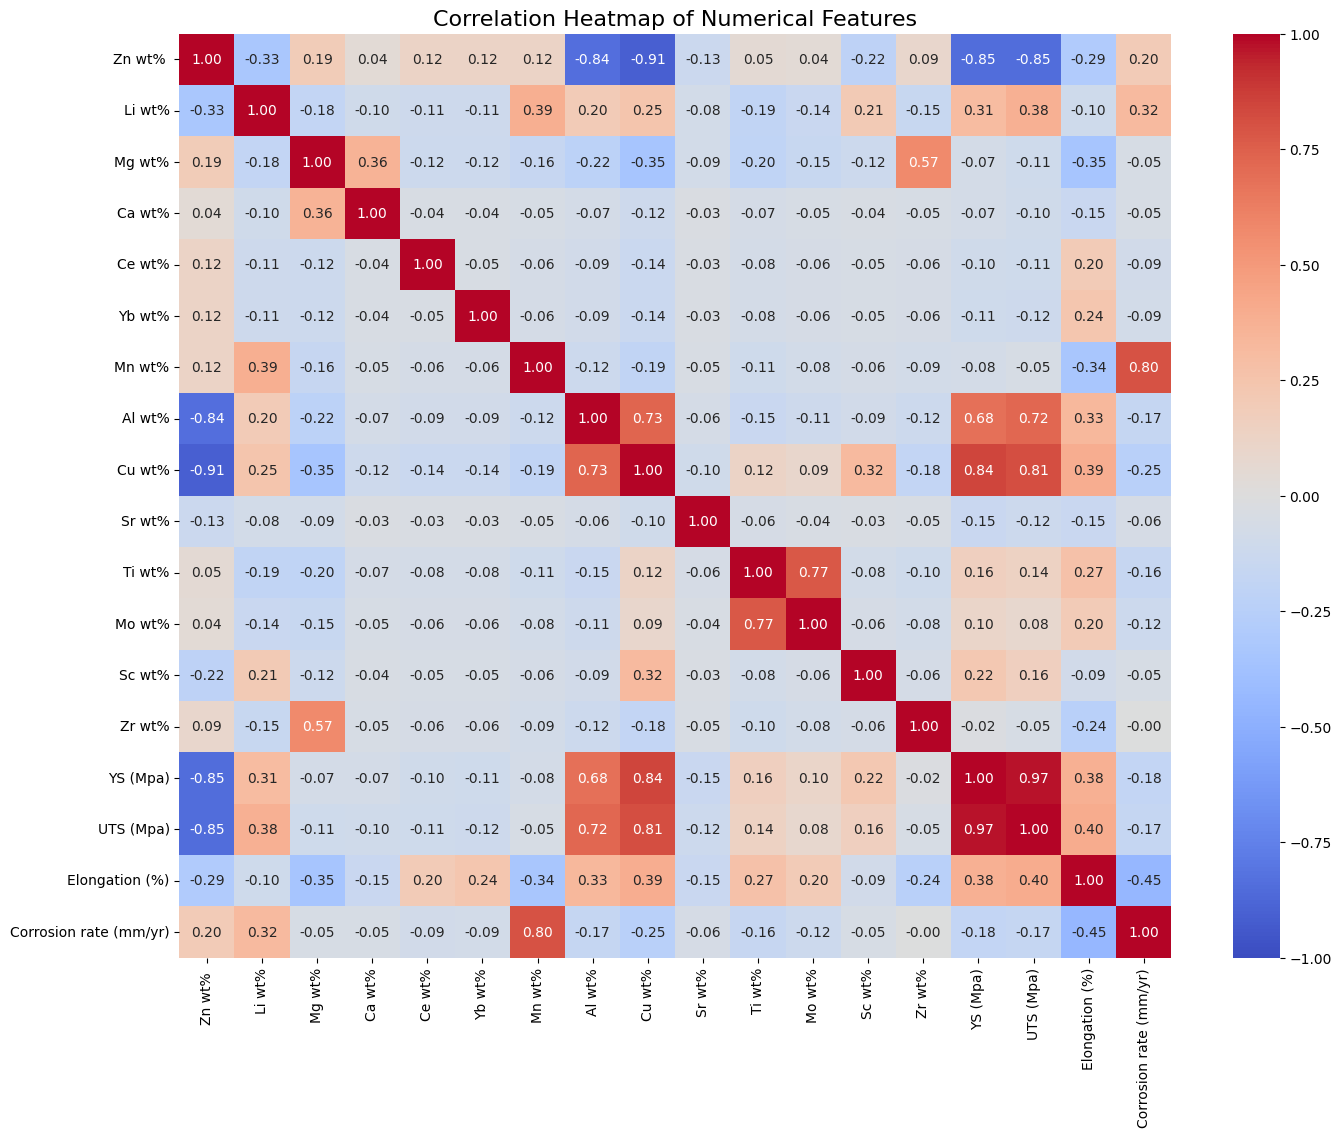

In [ ]:
import matplotlib.pyplot as plt
import seaborn as  sns

plt.figure(figsize=(16, 12))
sns.heatmap(
    df[numerical_cols].corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm',
    vmin=-1, 
    vmax=1
)  
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

In [9]:
pairplot_cols = [
    'YS (Mpa)', 
    'UTS (Mpa)', 
    'Elongation (%)',
    'Mg wt%',
    'Zn wt% ',
    'Cu wt%',
    'Corrosion rate (mm/yr)'
]

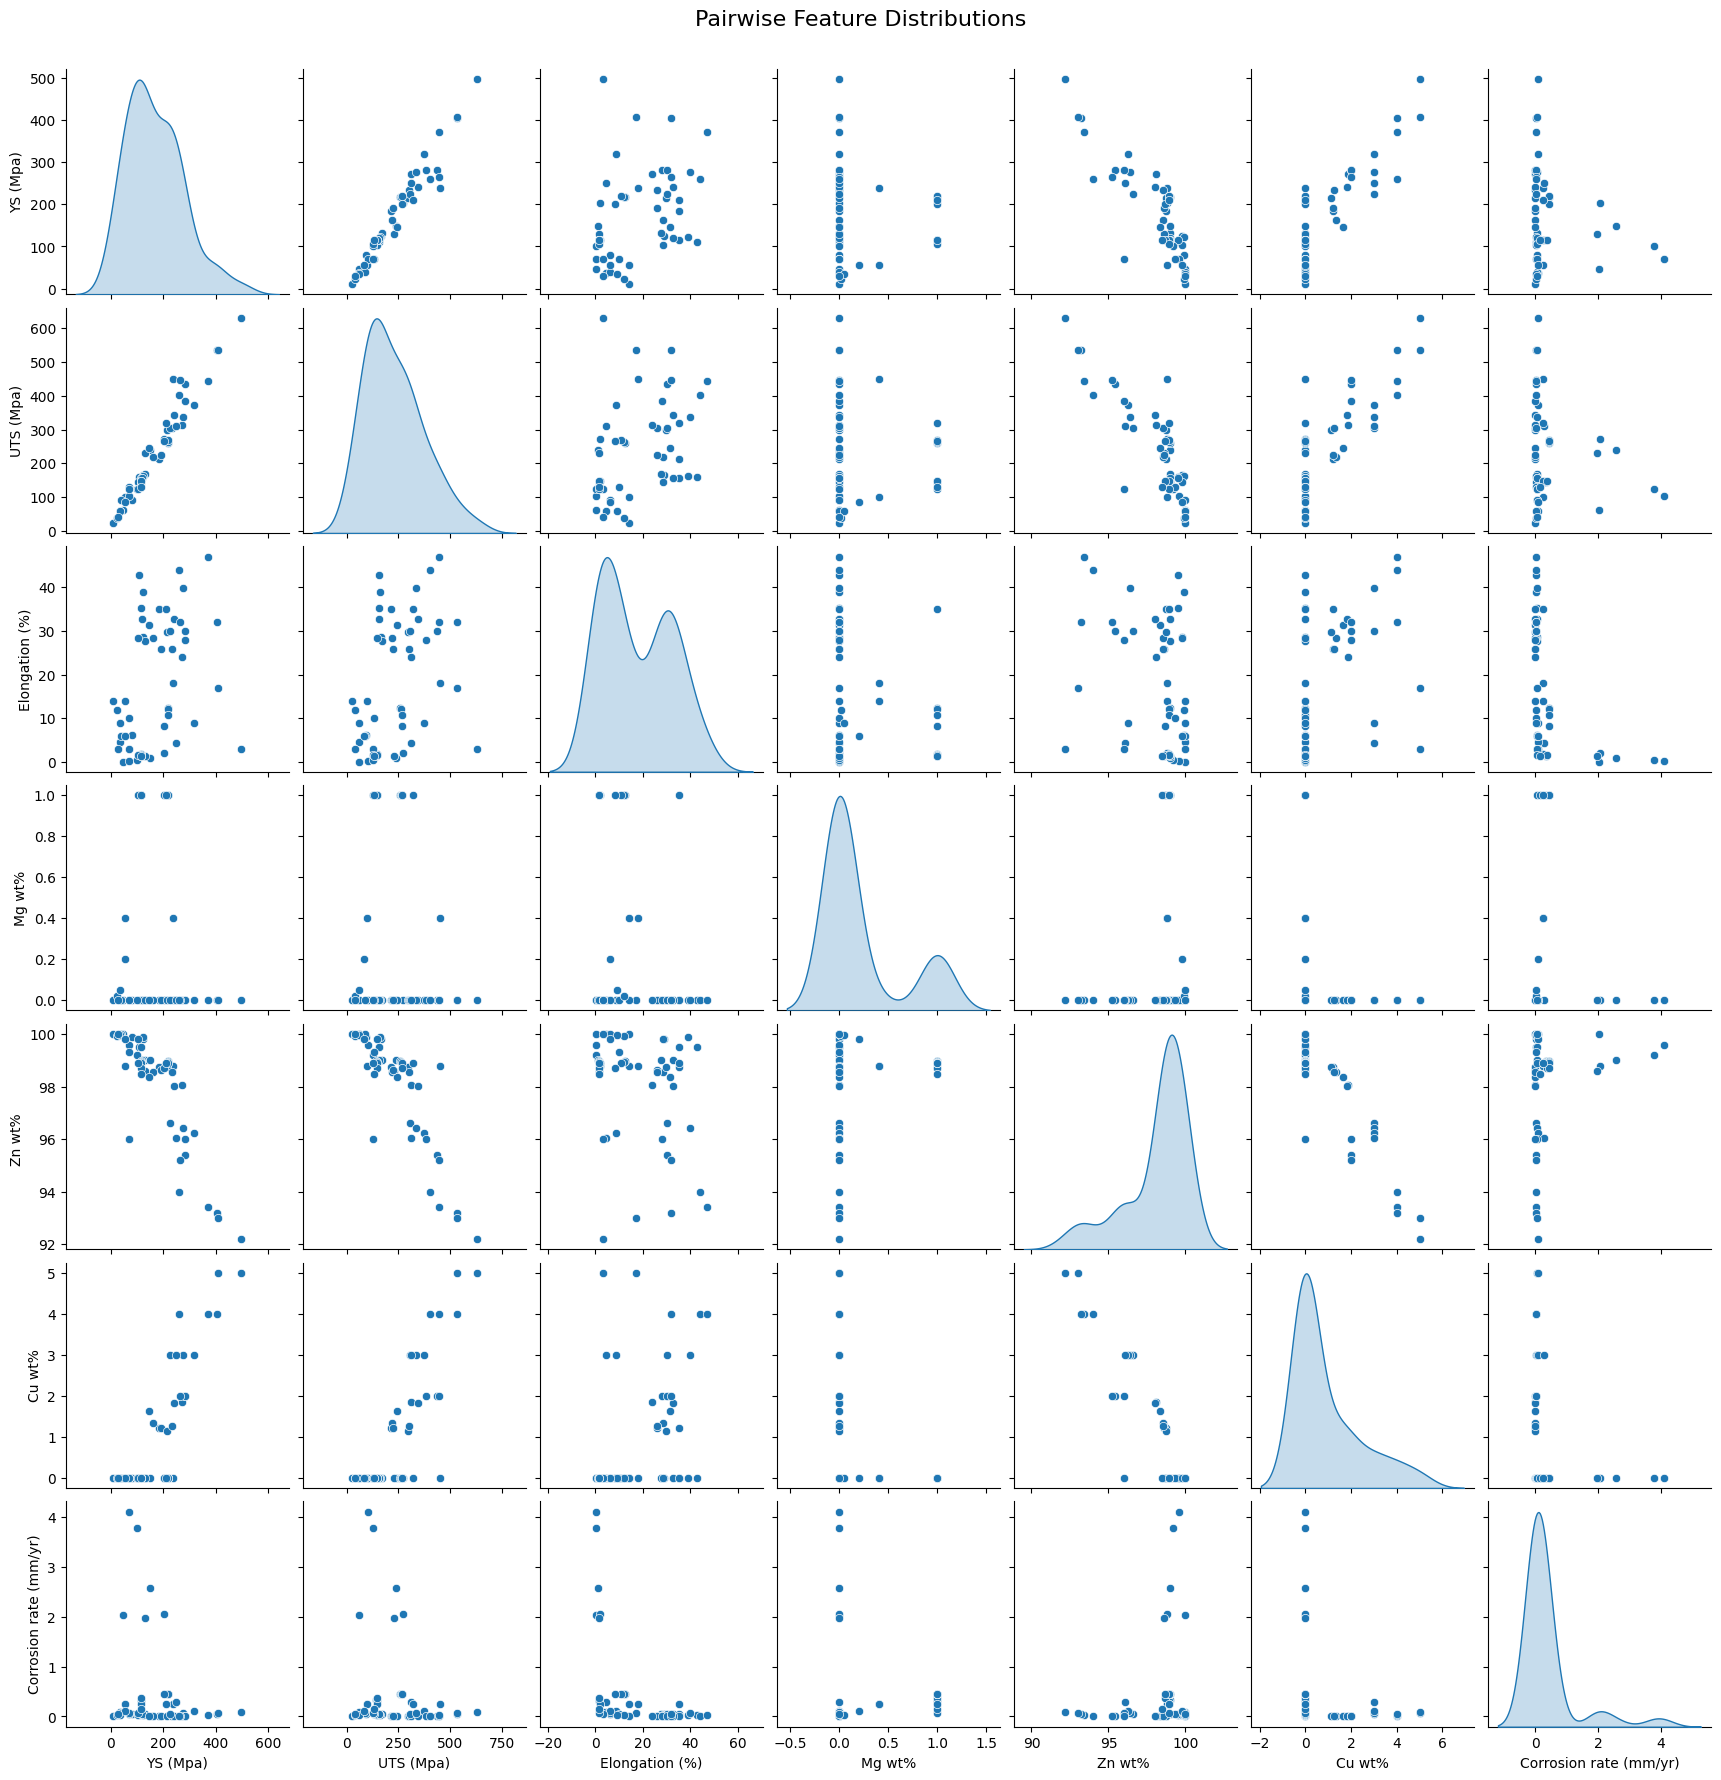

In [10]:
sns.pairplot(df[pairplot_cols], diag_kind='kde')
plt.suptitle('Pairwise Feature Distributions', y=1.02, fontsize=16)
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [13]:
y = df_processed['Corrosion rate (mm/yr)']
X = df_processed.drop(columns=['Corrosion rate (mm/yr)'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

X_scaled['t-SNE1'] = X_tsne[:, 0]
X_scaled['t-SNE2'] = X_tsne[:, 1]

In [17]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
t_sne_clusters = kmeans.fit_predict(X_tsne)

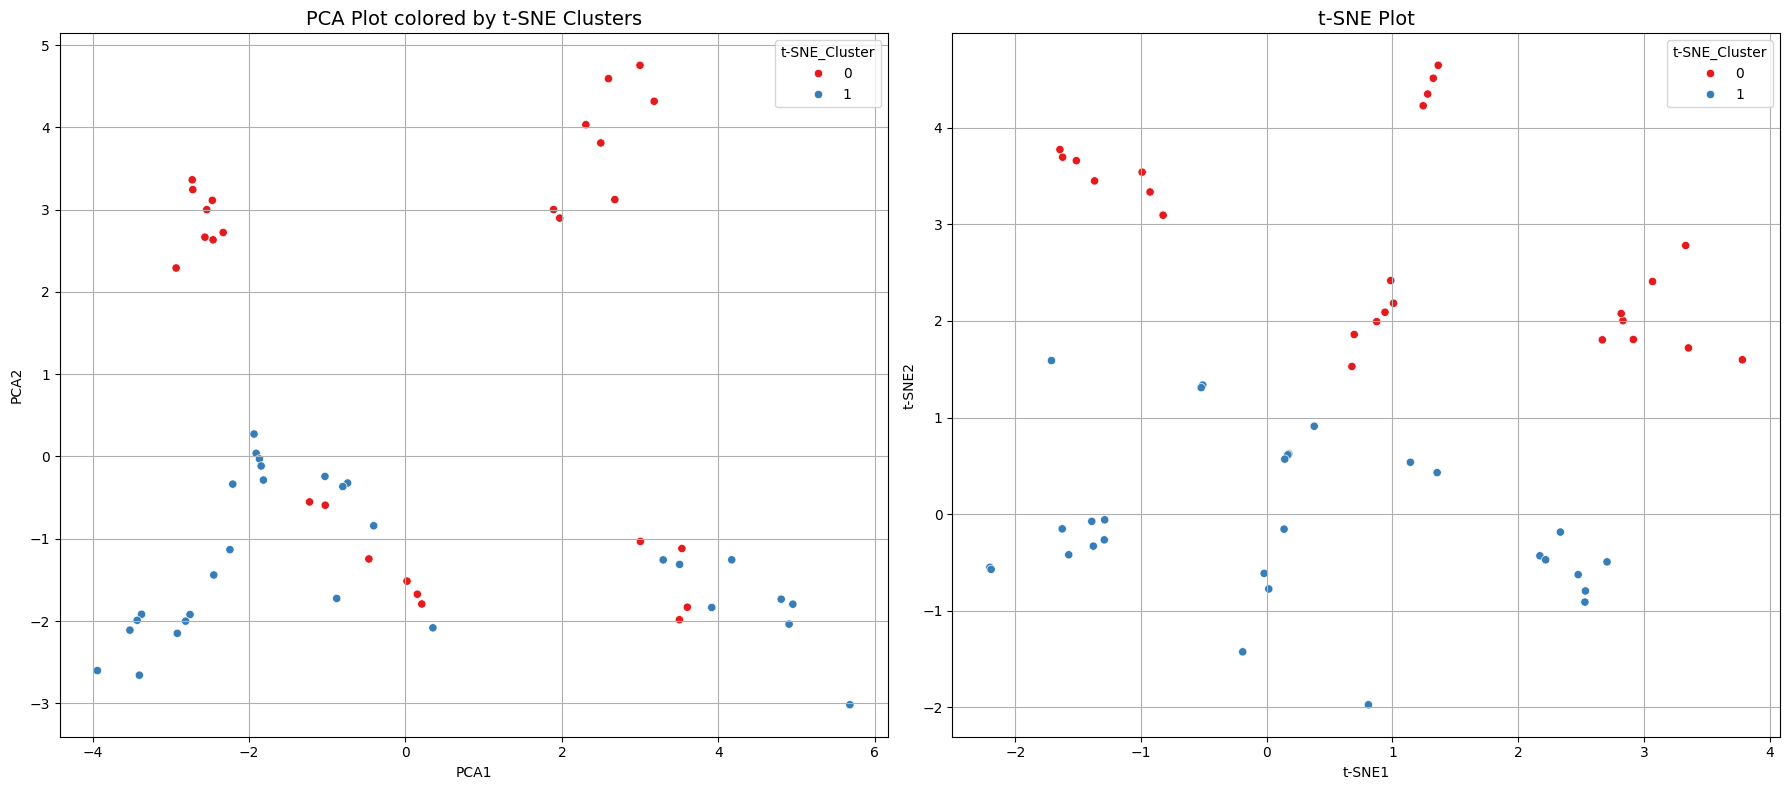

In [ ]:
plot_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
plot_df['t-SNE1'] = X_tsne[:, 0]
plot_df['t-SNE2'] = X_tsne[:, 1]
plot_df['t-SNE_Cluster'] = t_sne_clusters

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(
        data=plot_df, 
        x='PCA1', 
        y='PCA2', 
        hue='t-SNE_Cluster', 
        palette='Set1',  
        legend='full',
        ax=ax1
    )
ax1.set_title('PCA Plot colored by t-SNE Clusters', fontsize=14)
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax1.grid(True)

sns.scatterplot(
        data=plot_df, 
        x='t-SNE1', 
        y='t-SNE2', 
        hue='t-SNE_Cluster', 
        palette='Set1',
        legend='full',
        ax=ax2
    )
ax2.set_title('t-SNE Plot', fontsize=14)
ax2.set_xlabel('t-SNE1')
ax2.set_ylabel('t-SNE2')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso

rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42) 
dt = DecisionTreeRegressor(random_state=42)
models = {'Random Forest': rf, 'Gradient Boosting': gb, 'XGBoost': xgb, 'decision tree':dt}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=10, scoring='r2')
    print(f"{name}: Mean R^2 = {scores.mean():.4f} (Std: {scores.std():.4f})")

--- 10-Fold Cross-Validation Scores (R^2) ---
Random Forest: Mean R^2 = -139.3122 (Std: 414.4780)
Gradient Boosting: Mean R^2 = -16.6973 (Std: 49.0104)
XGBoost: Mean R^2 = -72.1346 (Std: 210.4792)
decision tree: Mean R^2 = -1.1008 (Std: 2.8292)


                         R2       MAE   accuracy
Random Forest      0.844932  0.209322  65.227321
Gradient Boosting  0.793616  0.216179   56.83992
XGBoost            0.953047  0.122318  74.171685
decision tree      0.796117  0.202629  71.505489


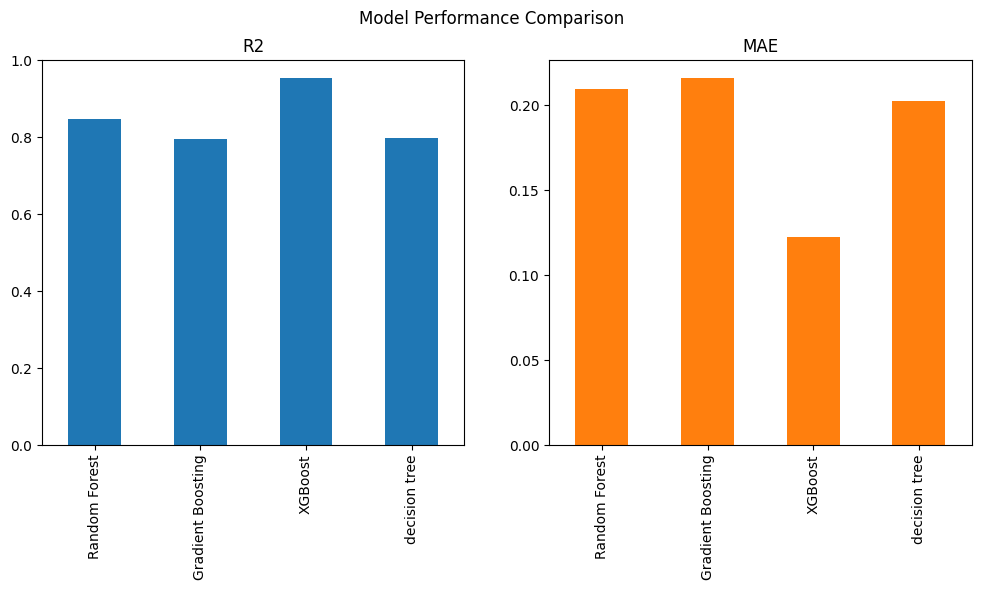

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    accuracy = 100 - mape

    results[name] = {'R2': r2, 'MAE': mae,'y_pred':y_pred, 'accuracy':accuracy}

results_df = pd.DataFrame(results).T[['R2', 'MAE']]
print(pd.DataFrame(results).T[['R2','MAE','accuracy']])

results_df.plot(kind='bar', subplots=True, layout=(1, 2), figsize=(12, 5), legend=False)
plt.suptitle("Model Performance Comparison")
plt.show()

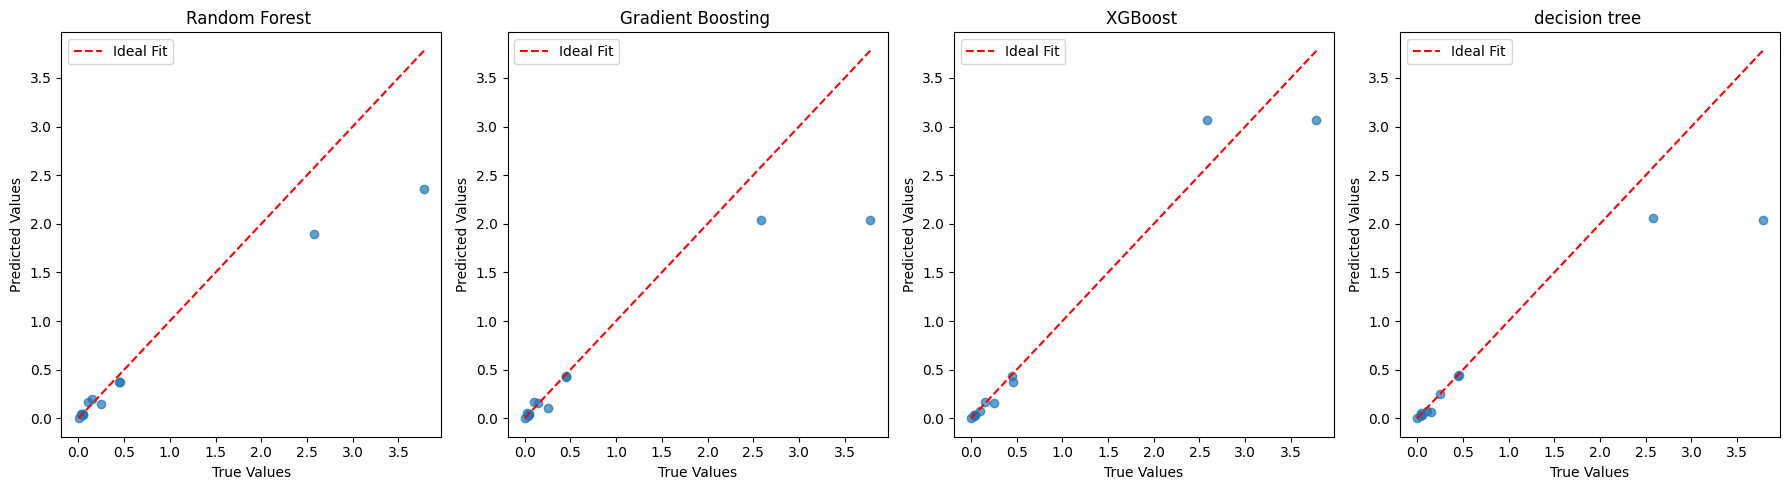

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for i, (name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.scatter(y_test, res['y_pred'], alpha=0.7)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{name} ")
    ax.legend()

plt.tight_layout()
plt.show()